# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy import stats

from imblearn.over_sampling import SMOTE

In [3]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [4]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [5]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\Wante\AppData\Local\Temp\ipykernel_22184\3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
C:\Users\Wante\AppData\Local\Temp\ipykernel_22184\3482823818.py:7: SettingWithCopyWarning: 
A value is

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [6]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [7]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

579     0
828     0
1164    1
372     0
295     0
       ..
835     0
1216    0
1653    0
559     0
684     0
Name: Attrition, Length: 1257, dtype: int64


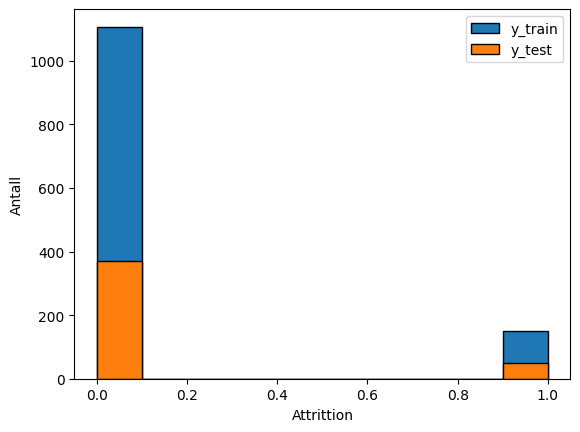

In [8]:
#TODO: visualiser y_train og y_test i et histogram

# Printer ut informasjon om kolonnen.
print(y_train)

# Visualisering av y_train og y_test i et histogram.
plt.hist(y_train, edgecolor="black", label="y_train")
plt.hist(y_test, edgecolor="black", label="y_test")
plt.ylabel("Antall")
plt.xlabel("Attrittion")
plt.legend(loc="upper right")

**Svar:**

Ut i fra histogrammet så vil jeg si at dette er et klassifiserings problem. Fra forskjell til et regresjons problem hvor man vil predikere en kontinuerlig verdi. I et klassifiserings problem er det en klasse eller kategori vi vil sette noe i og dette eksempelt er en binær klassifisering.

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


In [9]:
#TODO: repeterte kryssvalideringer for to modeller

"""Hyperparametersøk"""

# Lager en logistisk regresjons modell med skalert data.
logreg_pipeline = Pipeline([("scaler", StandardScaler()), ("log_reg", LogisticRegression())])

# Sett opp paramtere som skal søkes.
param_grid = {
    "log_reg__solver": ["lfbgs", "liblinear", "newton_cg","newton_cholesky", "sag", "saga"],
    "log_reg__max_iter": [100, 200, 300, 400, 500],
    "log_reg__penalty": ["l1", "l2", "elasticnet", "none"],
    "log_reg__class_weight": [None, "balanced"]
}

# Kjør gird search på logistisk regresjon.
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='accuracy')
# Fit modellen til søket.
grid_search.fit(X_train, y_train)
# Prediker target.
y_hat = grid_search.predict(X_train)

print(f"\nLogistisk regresjon grid search")
print(f"Beste parameter kombinasjon: {grid_search.best_params_}")
print(f"Beste skår fra Grid Search: {grid_search.best_score_}", "\n")

print(f"F1 skår: {f1_score(y_train, y_hat)}")
print(f"Nøyaktighet skår: {accuracy_score(y_train, y_hat)}")

# Lager er et nervalt nettverk med skalert data.
mlp_class_pipeline = Pipeline([("scaler", StandardScaler()), ("mlp", MLPClassifier())])

# Sett opp parametere som skal søkes.
param_grid = {
    "mlp__hidden_layer_sizes": [(32, 16), (64, 32)], 
    "mlp__activation": ["tanh", "relu"],
    "mlp__solver": ["sgd", "adam", "lfbgs"],
    "mlp__alpha": [0.0001, 0.001, 0.01], 
    "mlp__learning_rate": ["constant", "adaptive"]
}

# Kjør grid search på MLPClassifier.
grid_search = GridSearchCV(mlp_class_pipeline, param_grid, cv=5, scoring="accuracy")
# Fit modellen til søket.
grid_search.fit(X_train, y_train)
# Prediker target.
y_hat = grid_search.predict(X_train)

print(f"\nNervalt nettverk grid search")
print(f"Beste parameter kombinasjon: {grid_search.best_params_}")
print(f"Beste skår fra Grid Search: {grid_search.best_score_}", "\n")

print(f"F1 skår: {f1_score(y_train, y_hat)}")
print(f"Nøyaktighet skår: {accuracy_score(y_train, y_hat)}", "\n")

c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
950 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _


Logistisk regresjon grid search
Beste parameter kombinasjon: {'log_reg__class_weight': None, 'log_reg__max_iter': 100, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Beste skår fra Grid Search: 0.8878359577562766 

F1 skår: 0.3417085427135678
Nøyaktighet skår: 0.8957836117740652


c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklea


Nervalt nettverk grid search
Beste parameter kombinasjon: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 32), 'mlp__learning_rate': 'adaptive', 'mlp__solver': 'adam'}
Beste skår fra Grid Search: 0.8894295832542845 

F1 skår: 1.0
Nøyaktighet skår: 1.0 



c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklea

Gjennomsnitlig skår 

Logistisk regresjon
Gjennomsnitlig F1: 0.6106481914870008
Gjennomsnitlig Nøyaktighet: 0.8863179029912098 

Nervalt nettverk
Gjennomsnitlig F1: 0.6434186034583621
Gjennomsnitlig Nøyaktighet: 0.8795465756023526 

To-sidig T-test på f1 skår
T stat: -3.91144787481789
P Verdi: 0.00016924118768102473


c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


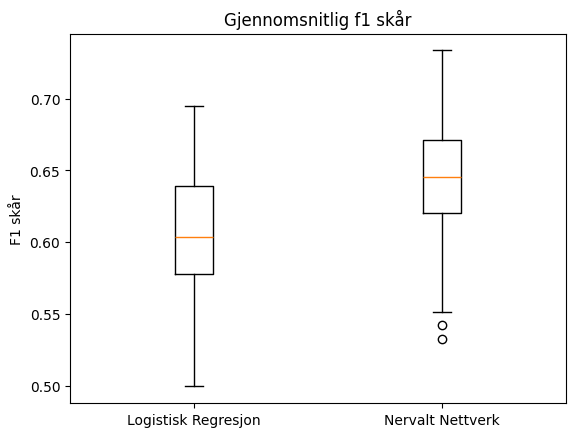

In [10]:

# Sett opp modellene med de beste parameterne.
logreg_pipeline = Pipeline([
            ("scaler", StandardScaler()), 
            ("log_reg", LogisticRegression(class_weight=None, max_iter=100, penalty="l1", solver="liblinear"))
        ])

mlp_class_pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("mlp", MLPClassifier(activation="tanh", alpha=0.01, hidden_layer_sizes=(32, 16), learning_rate="adaptive", solver="adam"))
])

# Sett opp repeterende kfold.
rfk = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

# Sett opp skåring for kryssvalidering.
scoring = ["f1_macro", "accuracy"]

# Kjør kryssvalidering på logistisk regresjon med f1 og nøyaktighet skåring.
logreg_results = cross_validate(logreg_pipeline, X_train, y_train, scoring=scoring, cv=rfk)

# Kjør kryssvalidering på nervalt nettverk med f1 og nøyaktighet skåring.
mlp_results = cross_validate(mlp_class_pipeline, X_train, y_train, scoring=scoring, cv=rfk)

print("Gjennomsnitlig skår", "\n")
print(f"Logistisk regresjon")
print(f"Gjennomsnitlig F1: {logreg_results["test_f1_macro"].mean()}")
print(f"Gjennomsnitlig Nøyaktighet: {logreg_results["test_accuracy"].mean()}", "\n")

print(f"Nervalt nettverk")
print(f"Gjennomsnitlig F1: {mlp_results["test_f1_macro"].mean()}")
print(f"Gjennomsnitlig Nøyaktighet: {mlp_results["test_accuracy"].mean()}", "\n")

# Boksplott av gjennomsnitlig f1 skår for logistisk regresjon og nervalt nettverk.
plt.boxplot([logreg_results["test_f1_macro"], mlp_results["test_f1_macro"]])
plt.title("Gjennomsnitlig f1 skår")
plt.ylabel("F1 skår")
plt.xticks([1, 2], ["Logistisk Regresjon", "Nervalt Nettverk"])

# To-sidig T-test av f1 skåringen.
t_stat, p_value = stats.ttest_ind(logreg_results["test_f1_macro"], mlp_results["test_f1_macro"])
print(f"To-sidig T-test på f1 skår")
print(f"T stat: {t_stat}")
print(f"P Verdi: {p_value}")

**Svar:**

Fra testene som er gjort så vil jeg si at nervalt nettverk (MLPClassifier) er den modellen som gjør det klart best. Selv om det ikke er så stor forskjell i hvertfall i mellom f1 skåringen, men det er den skåringen jeg ser mest på fordi nøyaktighet er ikke så veldig bra metrikk å se på når man har et ubalansert datasett. I tilegg så viser den to-sidige t-testen at det er en signifikant forskjell mellom modellene, med en p-verdi på 0.01.

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklea

Gjennomsnitlig skår etter oppsampling 

Logistisk regresjon
Gjennomsnitlig F1: 0.8898408365360657
Gjennomsnitlig Nøyaktighet: 0.8900604680142591 

Nervalt nettverk
Gjennomsnitlig F1: 0.9138442317827093
Gjennomsnitlig Nøyaktighet: 0.9140446155888992 

To-sidig T-test på f1 skår etter oppsampling
T stat: -8.176556055690819
P Verdi: 1.0641043865395744e-12


c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


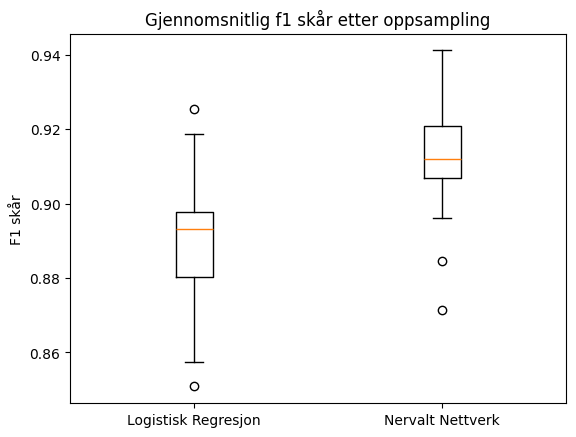

In [11]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE

# Sett opp imbalanced learn og SMOTE til oppsampling. 
sampler = SMOTE(random_state=1)
X_upsample, y_upsample = sampler.fit_resample(X_train, y_train)

# Kjør kryssvalidering på logistisk regresjon med f1 og nøyaktighet skåring.
logreg_results_resample = cross_validate(logreg_pipeline, X_upsample, y_upsample, scoring=scoring, cv=rfk)

# Kjør kryssvalidering på nervalt nettverk med f1 og nøyaktighet skåring.
mlp_results_resample = cross_validate(mlp_class_pipeline, X_upsample, y_upsample, scoring=scoring, cv=rfk)

print("Gjennomsnitlig skår etter oppsampling", "\n")
print(f"Logistisk regresjon")
print(f"Gjennomsnitlig F1: {logreg_results_resample["test_f1_macro"].mean()}")
print(f"Gjennomsnitlig Nøyaktighet: {logreg_results_resample["test_accuracy"].mean()}", "\n")

print(f"Nervalt nettverk")
print(f"Gjennomsnitlig F1: {mlp_results_resample["test_f1_macro"].mean()}")
print(f"Gjennomsnitlig Nøyaktighet: {mlp_results_resample["test_accuracy"].mean()}", "\n")

# Boksplott av gjennomsnitlig f1 skår for logistisk regresjon og nervalt nettverk.
plt.boxplot([logreg_results_resample["test_f1_macro"], mlp_results_resample["test_f1_macro"]])
plt.title("Gjennomsnitlig f1 skår etter oppsampling")
plt.ylabel("F1 skår")
plt.xticks([1, 2], ["Logistisk Regresjon", "Nervalt Nettverk"])

# To-sidig T-test av f1 skåringen.
t_stat, p_value = stats.ttest_ind(logreg_results_resample["test_f1_macro"], mlp_results_resample["test_f1_macro"])
print(f"To-sidig T-test på f1 skår etter oppsampling")
print(f"T stat: {t_stat}")
print(f"P Verdi: {p_value}")


**Svar:**

Jeg er litt usikker på hva som skjer med p-veriden etter oppsampling, men hvis jeg skal tolke den så sier den jo egentlig at det ikke er noe signifikant forskjell mellom logistisk regresjon og nervalt nettverk. Hvis jeg ser på den gjennomsnitlige f1 skåren og boksplottet så er nervalt nettverk bitte litt bedre, men ikke så veldig mye bedre. Jeg velger uansett å gå videre med nervalt nettverk fordi den er litt bedre enn logistisk regresjon.

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [12]:
#TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene

# Fit testdataen til modellen.
mlp_class_pipeline.fit(X_test, y_test)

# Prediker tets veridene.
y_hat = mlp_class_pipeline.predict(X_test)

# Bereng metrikker.
accuracy = accuracy_score(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat)
# Beregning av spesifistet.
cm = confusion_matrix(y_test, y_hat)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tp + fp) 

print("Metrikker for testing av modellen")
print(f"Nøyaktighet: {accuracy}")
print(f"Presisjon: {precision}")
print(f"Sensitivitet: {recall}")
print(f"Spesifistet: {specificity}")
print(f"F1: {f1}")

Metrikker for testing av modellen
Nøyaktighet: 0.9785714285714285
Presisjon: 0.9555555555555556
Sensitivitet: 0.86
Spesifistet: 8.177777777777777
F1: 0.9052631578947369


c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [16]:
#TODO: Gjør kjønnsbasert analyse på testdataene

# Lager test sett med hvert kjønn.
X_test_male = X_test[X_test["Gender"] == 0]
X_test_female = X_test[X_test["Gender"] == 1]

y_test_male = y_test[X_test["Gender"] == 0]
y_test_female = y_test[X_test["Gender"] == 1]

# Lager treningsett med hvert kjønn.
X_train_male = X_train[X_train["Gender"] == 0]
X_train_female = X_train[X_train["Gender"] == 1]

y_train_male = y_train[X_train["Gender"] == 0]
y_train_female = y_train[X_train["Gender"] == 1]

# Fit mann testdataen til modellen.
mlp_class_pipeline.fit(X_train_male, y_train_male)

# Prediker tets veridene.
y_hat_male = mlp_class_pipeline.predict(X_test_male)

# Bereng metrikker for mann.
accuracy = accuracy_score(y_test_male, y_hat_male)
precision = precision_score(y_test_male, y_hat_male)
recall = recall_score(y_test_male, y_hat_male)
f1 = f1_score(y_test_male, y_hat_male)
# Beregning av spesifistet.
cm = confusion_matrix(y_test_male, y_hat_male)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tp + fp) 

print("Metrikker for testing av modellen på menn")
print(f"Nøyaktighet: {accuracy}")
print(f"Presisjon: {precision}")
print(f"Sensitivitet: {recall}")
print(f"Spesifistet: {specificity}")
print(f"F1: {f1}", "\n")

# Fit kvinne testdataen til modellen.
mlp_class_pipeline.fit(X_train_female, y_train_female)

# Prediker tets veridene.
y_hat_female = mlp_class_pipeline.predict(X_test_female)

# Bereng metrikker for mann.
accuracy = accuracy_score(y_test_female, y_hat_female)
precision = precision_score(y_test_female, y_hat_female)
recall = recall_score(y_test_female, y_hat_female)
f1 = f1_score(y_test_female, y_hat_female)
# Beregning av spesifistet.
cm = confusion_matrix(y_test_female, y_hat_female)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tp + fp) 

print("Metrikker for testing av modellen på kvinner")
print(f"Nøyaktighet: {accuracy}")
print(f"Presisjon: {precision}")
print(f"Sensitivitet: {recall}")
print(f"Spesifistet: {specificity}")
print(f"F1: {f1}")

c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrikker for testing av modellen på menn
Nøyaktighet: 0.8379446640316206
Presisjon: 0.3333333333333333
Sensitivitet: 0.1388888888888889
Spesifistet: 13.8
F1: 0.19607843137254902 

Metrikker for testing av modellen på kvinner
Nøyaktighet: 0.8862275449101796
Presisjon: 0.3076923076923077
Sensitivitet: 0.2857142857142857
Spesifistet: 11.076923076923077
F1: 0.2962962962962963


c:\Users\Wante\OneDrive\USN Høst 2024\BTS4210-1 Datautvinning og Analyse\DMBA2024\oblig2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**Svar:**

Etter å ha fikser opp i modellen, så kan jeg se at den gjør det mye dårligere og det på begge kjønn. Nøyaktigheten på begge er relativ lik, men en ting som er viktig å huske på er at nøyaktighet tar ikke for seg datasett som er ubalansert som er tilfelelt med dette datasettet. Slik det set ut nå så er den ca 10% værre på menn enn kvinner i forhold til f1 skår og sensitivitet. Første hintetet om et ubalansert datasett dukket allrede opp i histogrammet. Måten å fikse dette på er å få tak i mer data om menn, bruke resample teknikker med imbalanced learn/SMOTE eller prøve å tune modellen enda bedre med hyperparametersøk.

Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [14]:
#!pip freeze > requirements.txt